# Assignment 2 - Feature extraction and classification

Note: This notebook file for the assignment has deviations from the course guide with respect to the structure, sentence framing, question framing and numbering. Please consider this notebook file structure as the final structure and follow this.

In this assignment, you are expected to

(1) extract global features from CIFAR10 dataset with one of the pre-trained neural networks available in pytorch,

(2) classify the dataset using the traditional k-Nearest Neighbours classifier,

and

(3) implement k-fold cross-validation to evaluate your model.

------------------------

In [36]:
# Load all the needed packages for this assignment here
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold

When working with Pytorch, dataloader() is a must to know function. Read more about this function and the parameters it accepts in https://blog.paperspace.com/dataloaders-abstractions-pytorch/

In [ ]:
from torch.utils.data import DataLoader

The variable 'transform' encapsulates the needed transformations of our data. Read more about transforms in https://blog.paperspace.com/dataloaders-abstractions-pytorch/

In [ ]:
transform = transforms.Compose([
    # resize
    transforms.Resize(32),
    # center-crop
    transforms.CenterCrop(32),
    # to-tensor
    transforms.ToTensor(),
    # normalize
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

### INPUT DATASET

Load the CIFAR10 dataset from Pytorch

In [4]:
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=False)

#### Exercise 2.1 - Dataset preparation

**a)** Write a function **'train_test_split(dataset, ratio)'** which takes a dataset array as an input and returns two dataset arrays- one for training and another for testing.


In [ ]:
def train_test_split(dataset, ratio):
    # Ex. 2.1a 
    dataset = list(dataset) 
    split_idx = int(len(dataset) * ratio)
    training_data = dataset[:split_idx]
    testing_data = dataset[split_idx:]
    
    return training_data, testing_data


### FEATURE EXTRACTION

Extract descriptros from the images in your train and test dataset. The dataset split should remain the same for all the experiments if you want to be fair when comparing performance.

#### Exercise 2.2 - Feature 1 - RGB descriptor

Implement the same code you wrote for extracting the overall RGB descriptors(of size n x 24) as in assignment 1 here.

In [23]:
# Ex.2.2 
descriptors = []
for img, _ in dataset:
    img_np = np.array(img)  
    channel_hists = [np.histogram(img_np[..., i], bins=8, range=(0, 255))[0] for i in [0,1,2]]
    descriptors.append(np.concatenate(channel_hists))

rgb_descriptors = np.array(descriptors)
print(rgb_descriptors.shape)

/tmp/ipykernel_8498/3830127823.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  img_np = np.array(img)


(50000, 24)


#### Exercise 2.3 - Feature 2 - Extract CNN descriptors using pre-traind networks

Load one of the pretrained network (resnet, alexnet, vgg, squeezenet, densenet, inception) from pytorch to extract global features from the images present in the dataset. 
We will use the output values from the layer present just before the fully connected layer of the deep network as a descriptor, i.e. we will remove the last fully-connected layer. Therefore, after feed-forwarding the input image through the network, we save the output as the descriptor of the image. We do this for all the images present in the dataset to get the overall CNN descriptors.

You may refer to this link for debugging purposes - https://stackoverflow.com/questions/52548174/how-to-remove-the-last-fc-layer-from-a-resnet-model-in-pytorch

In [24]:
import torch.nn as nn
from torchvision import models
dataset = list(dataset)
 
# Ex.2.3
model = models.squeezenet1_0(pretrained=True)
model.classifier = nn.Identity()
model.eval()

cnn_descriptors = []
for img, _ in dataset:
    img = img.unsqueeze(0)  # Add batch dimension (1,)
    with torch.no_grad():
        features = model(img)  # Forward pass through the model
    cnn_descriptors.append(features.flatten().cpu().numpy())  # Flatten features
cnn_descriptors = np.array(cnn_descriptors)
print(cnn_descriptors.shape)

/home/daniellizarazo/Repositories/UTwente/DataScience/venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/daniellizarazo/Repositories/UTwente/DataScience/venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(50000, 512)


### PERFORMANCE EVALUATION

#### Exercise 2.4 - Error function

Implement a function to evaluate the accuracy of your prediction. We will rely on the evaluation metric 'accuracy'.

You are suggested to also use f-score, recall and precision. Have a look at https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html 

In [27]:
def accuracy_metric(actual, predicted):
    
    # Ex.2.4 your code here
    accuracy_value = accuracy_score(actual, predicted)
    precision, recall, fscore, _ = precision_recall_fscore_support(actual, predicted, average='macro')  
    
    return accuracy_value, precision, recall, fscore

### TRAIN AND TEST YOUR MODEL

#### Exercise 2.5 - k Nearest Neighbour model

For this exercise, first split the extracted overall RGB and CNN descriptor to train and test sets with the help of the 'train_test_split()' function that you implemented before.

**a)** Apply the classifier with different values of k (number of nearest neighbours) to the train **RGB descriptor** set and evaluate the performance of your models using the accuracy_metric() function that you implemented before.

You can have a look at the documentation to understand the parameters that define the learning of the model,
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Use your k-NN - play with the value of the parameters to see how the model performs
kvalue_list = [2,4,6,10,15] 

# Ex.2.5a
dataset_train, dataset_test = train_test_split(dataset, 0.8)

def split_features_labels(dataset):
    images, labels = zip(*dataset)
    return np.array(images), np.array(labels)

labels_train = split_features_labels(dataset_train)[1]
labels_test = split_features_labels(dataset_test)[1]

rgb_train, rgb_test = train_test_split(rgb_descriptors, 0.8)
cnn_train, cnn_test = train_test_split(cnn_descriptors, 0.8)

results = {}
for k in kvalue_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(rgb_train, labels_train) 

    predictions = knn.predict(rgb_test)  
    accuracy, precision, recall, fscore = accuracy_metric(labels_test, predictions) 

    results[k] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'fscore': fscore}

for k, metrics in results.items():
    print(f"Results for k={k}:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F-Score: {metrics['fscore']:.4f}")

Results for k=2:
  Accuracy: 0.1319
  Precision: 0.1232
  Recall: 0.1314
  F-Score: 0.1161
Results for k=4:
  Accuracy: 0.1228
  Precision: 0.1223
  Recall: 0.1224
  F-Score: 0.1137
Results for k=6:
  Accuracy: 0.1375
  Precision: 0.1303
  Recall: 0.1374
  F-Score: 0.1279
Results for k=10:
  Accuracy: 0.1436
  Precision: 0.1375
  Recall: 0.1435
  F-Score: 0.1346
Results for k=15:
  Accuracy: 0.1523
  Precision: 0.1459
  Recall: 0.1522
  F-Score: 0.1449


**b)** Apply the classifier with different values of k (number of nearest neighbours) to the train **CNN descriptor** and evaluate the performance of your models using the accuracy_metric() function that you implemented before.

In [31]:
# Ex.2.5b
results = {}
for k in kvalue_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(cnn_train, labels_train) 

    predictions = knn.predict(cnn_test)  
    accuracy, precision, recall, fscore = accuracy_metric(labels_test, predictions) 

    results[k] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'fscore': fscore}

for k, metrics in results.items():
    print(f"Results for k={k}:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F-Score: {metrics['fscore']:.4f}")

Results for k=2:
Accuracy: 0.4049
Precision: 0.4396
Recall: 0.4047
F-Score: 0.4023
Results for k=4:
Accuracy: 0.4642
Precision: 0.4707
Recall: 0.4641
F-Score: 0.4630
Results for k=6:
Accuracy: 0.4848
Precision: 0.4880
Recall: 0.4847
F-Score: 0.4838
Results for k=10:
Accuracy: 0.5007
Precision: 0.5008
Recall: 0.5006
F-Score: 0.4981
Results for k=15:
Accuracy: 0.5053
Precision: 0.5061
Recall: 0.5051
F-Score: 0.5027


#### Exercise 2.6 - Visualize results 

**a)** Since you already applied PCA to the extracted overall RGB descriptor in assignment 1, now apply PCA to the extracted overall **CNN descriptor**.

Steps to follow:

1) Choose the kNN classifier with k value that gave you the best results in the previous exercise and use it to make predictions on your train CNN descriptor set.

2) Apply PCA on the train set and select the first 2 principal components to represent each sample.

3) Plot the principal components representing the samples with empty circles. Use one color per ground truth class lables. On top of this, plot the samples again but now with filled circles. For these filled circles, use the color of the class predicted per sample in step 1. You can note that misclassifications will make the colours not coincide.

/tmp/ipykernel_8498/2187811629.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_classes)


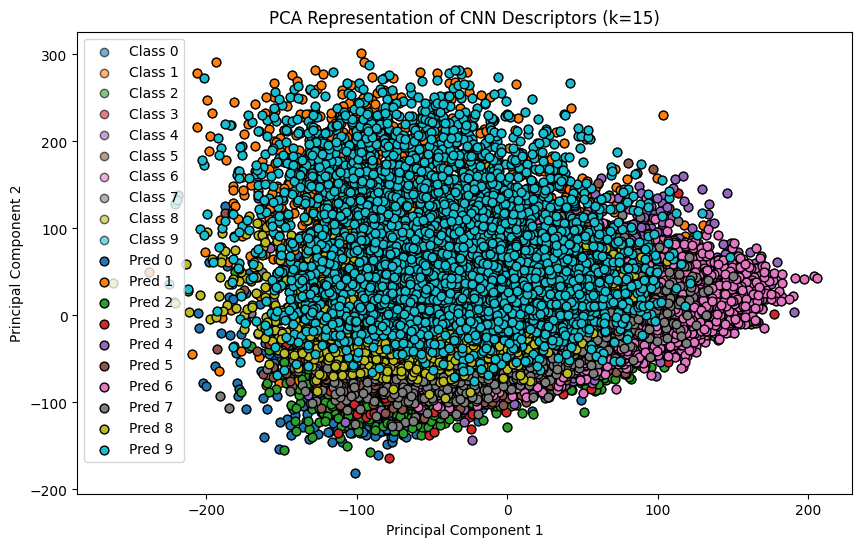

In [ ]:
# Ex.2.6a
# 1 
best_k = max(results, key=lambda k: results[k]['accuracy'])
# 2
knn_cnn = KNeighborsClassifier(n_neighbors=best_k)
knn_cnn.fit(cnn_train, labels_train) 
# 3
pca = PCA(n_components=2)
cnn_train_pca = pca.fit_transform(cnn_train)  
cnn_test_pca = pca.transform(cnn_test) 


train_predictions = knn_cnn.predict(cnn_train)
num_classes = len(set(labels_train))
colors = plt.cm.get_cmap("tab10", num_classes)
plt.figure(figsize=(10, 6))
for label in np.unique(labels_train):
    idx = np.where(labels_train == label)
    plt.scatter(cnn_train_pca[idx, 0], cnn_train_pca[idx, 1], 
                color=colors(label), edgecolors='black', marker='o', label=f'Class {label}', alpha=0.6)

# Plot predicted labels (filled circles)
for label in np.unique(train_predictions):
    idx = np.where(train_predictions == label)
    plt.scatter(cnn_train_pca[idx, 0], cnn_train_pca[idx, 1], 
                color=colors(label), edgecolors='black', marker='o', alpha=1, label=f'Pred {label}', s=40)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title(f"PCA Representation of CNN Descriptors (k={best_k})")
plt.legend()
plt.show()

**b)** Repeat the steps mentioned before but now on the test CNN descriptor set. 

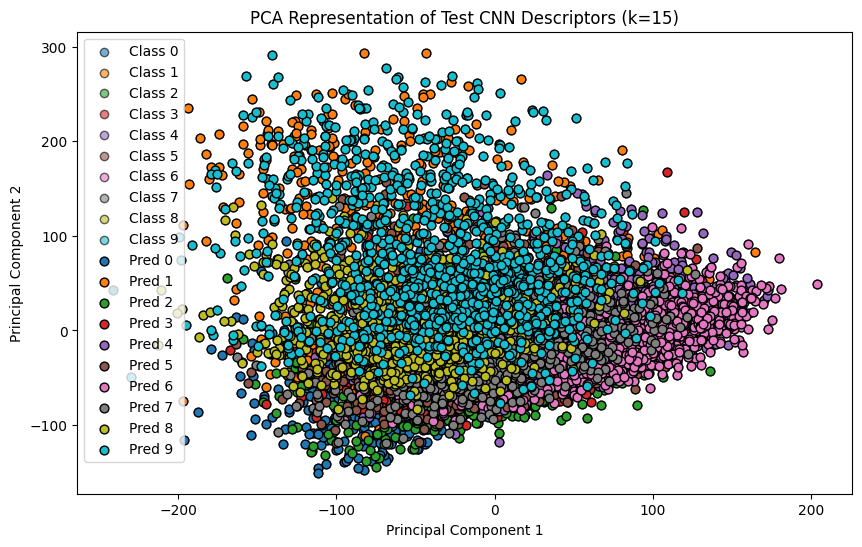

In [35]:
# Ex.2.6b
# Step 1: Predict labels for the test set
test_predictions = knn_cnn.predict(cnn_test)

# Step 2: Plot PCA-transformed test set
plt.figure(figsize=(10, 6))

# Plot ground truth labels (empty circles)
for label in np.unique(labels_test):
    idx = np.where(labels_test == label)
    plt.scatter(cnn_test_pca[idx, 0], cnn_test_pca[idx, 1], 
                color=colors(label), edgecolors='black', marker='o', label=f'Class {label}', alpha=0.6)

# Plot predicted labels (filled circles)
for label in np.unique(test_predictions):
    idx = np.where(test_predictions == label)
    plt.scatter(cnn_test_pca[idx, 0], cnn_test_pca[idx, 1], 
                color=colors(label), edgecolors='black', marker='o', alpha=1, label=f'Pred {label}', s=40)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title(f"PCA Representation of Test CNN Descriptors (k={best_k})")
plt.legend()
plt.show()


#### Exercise 2.7 - kNN with k-Fold cross-validation

Assess the performance of your implemented kNN using k-Fold cross-validation. 

Run your implemented function evaluating for k (fold) = 2, 5 and 10. You can rely on the kNN that performed best in the previous exercises.
Report the average accuracy and the standard deviation.

In [41]:
# Load packages
from sklearn.model_selection import KFold
import numpy as np
from sklearn.utils import shuffle

# Ex.2.7
k_list = [2, 5, 10]  
avg_acc_list = []  # Stores results per k

# Use the best kNN from previous exercises
best_knn = KNeighborsClassifier(n_neighbors=best_k)

cnn_train = np.array(cnn_train)
labels_train = np.array(labels_train)

for k in k_list:
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    acc_per_fold = []
    
    for train_idx, val_idx in skf.split(cnn_train, labels_train):
        X_train, X_val = cnn_train[train_idx], cnn_train[val_idx]
        y_train, y_val = labels_train[train_idx], labels_train[val_idx]

        # Train kNN classifier
        best_knn.fit(X_train, y_train)

        # Predict and evaluate
        predictions = best_knn.predict(X_val)
        acc_per_fold.append(accuracy_score(y_val, predictions))

    avg_acc_list.append(acc_per_fold)


In [42]:
## SUGGESTION ON HOW TO PRESENT PERFORMANCE OF YOUR KFOLD CROSS VALIDATION ANALYSIS

print('Summary results:')
print(' ')
print(' ')
for i,k in enumerate(k_list):
    print(k,'-fold cross validation:')  
    print('Accuracies per fold: ', avg_acc_list[i]) 
    
    avg_acc = round(sum(avg_acc_list[i])/k,2)
    std_list= round(np.std(avg_acc_list[i]),2)
    print('Average accuracy: ', avg_acc,'+-', std_list) 
    print(' ')

Summary results:
 
 
2 -fold cross validation:
Accuracies per fold:  [0.497, 0.49155]
Average accuracy:  0.49 +- 0.0
 
5 -fold cross validation:
Accuracies per fold:  [0.50925, 0.51, 0.508125, 0.5005, 0.512875]
Average accuracy:  0.51 +- 0.0
 
10 -fold cross validation:
Accuracies per fold:  [0.5145, 0.507, 0.51925, 0.517, 0.513, 0.503, 0.498, 0.50125, 0.5125, 0.50025]
Average accuracy:  0.51 +- 0.01
 


### [Optional] Exercise: further explore by: 
- implement other classifiers such as SVM or Random Forest, 
- extract other descriptors from the images such as objects or other local features,
- implement the evaluation metrics: recall, precision and f-score.